# HW07 — Clustering (KMeans / DBSCAN / Agglomerative)

Этот ноутбук соответствует требованиям HW07: EDA, препроцессинг, сравнение алгоритмов, внутренние метрики, PCA-визуализация, устойчивость, сохранение артефактов.

`Выбраны датасеты: **01, 02, 03**.


In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.decomposition import PCA

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

ARTIFACTS_DIR = "artifacts"
FIG_DIR = os.path.join(ARTIFACTS_DIR, "figures")
LABELS_DIR = os.path.join(ARTIFACTS_DIR, "labels")

os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(LABELS_DIR, exist_ok=True)

## Вспомогательные функции

- загрузка + базовый EDA
- вычисление метрик (с учётом шума DBSCAN)
- PCA(2D) scatter
- подбор параметров для KMeans / DBSCAN / Agglomerative


In [2]:
def load_dataset(path: str):
    df = pd.read_csv(path)
    sample_id = df["sample_id"].copy()
    X = df.drop(columns=["sample_id"]).copy()
    return df, sample_id, X


def basic_eda(df: pd.DataFrame):
    display(df.head())
    display(df.info())
    display(df.describe(include="all"))
    miss = df.isna().mean().sort_values(ascending=False)
    display(miss)


def compute_metrics(X, labels, *, is_dbscan=False):
    labels = np.asarray(labels)

    noise_share = None
    X_eval, y_eval = X, labels

    if is_dbscan:
        noise_mask = labels == -1
        noise_share = float(noise_mask.mean())
        X_eval = X[~noise_mask]
        y_eval = labels[~noise_mask]

    uniq = np.unique(y_eval)
    if len(uniq) < 2:
        return {
            "silhouette": None,
            "davies_bouldin": None,
            "calinski_harabasz": None,
            "noise_share": noise_share,
            "n_clusters": int(len(uniq)),
        }

    return {
        "silhouette": float(silhouette_score(X_eval, y_eval)),
        "davies_bouldin": float(davies_bouldin_score(X_eval, y_eval)),
        "calinski_harabasz": float(calinski_harabasz_score(X_eval, y_eval)),
        "noise_share": noise_share,
        "n_clusters": int(len(uniq)),
    }


def pca_scatter(X, labels, title: str, save_path: str):
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    Z = pca.fit_transform(X)

    plt.figure()
    plt.scatter(Z[:, 0], Z[:, 1], c=labels, s=12)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.savefig(save_path, dpi=160)
    plt.show()


def pick_best_by_silhouette(results_rows):
    filtered = [r for r in results_rows if r.get("silhouette") is not None]
    if not filtered:
        return None
    return max(filtered, key=lambda r: r["silhouette"])


def search_kmeans(X_scaled, k_min=2, k_max=15):
    rows = []
    ks = list(range(k_min, k_max + 1))
    for k in ks:
        model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        labels = model.fit_predict(X_scaled)
        m = compute_metrics(X_scaled, labels)
        rows.append({"algo": "kmeans", "k": k, **m})

    best = pick_best_by_silhouette(rows)

    plt.figure()
    plt.plot([r["k"] for r in rows], [r["silhouette"] if r["silhouette"] is not None else np.nan for r in rows])
    plt.title("KMeans: silhouette vs k")
    plt.xlabel("k")
    plt.ylabel("silhouette")
    plt.tight_layout()
    return rows, best


def search_agglomerative(X_scaled, k_min=2, k_max=15, linkages=("ward", "average")):
    rows = []
    for linkage in linkages:
        for k in range(k_min, k_max + 1):
            model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
            labels = model.fit_predict(X_scaled)
            m = compute_metrics(X_scaled, labels)
            rows.append({"algo": "agglomerative", "k": k, "linkage": linkage, **m})

    best = pick_best_by_silhouette(rows)
    return rows, best


def search_dbscan(X_scaled, eps_grid=None, min_samples_grid=(5, 10)):
    if eps_grid is None:
        eps_grid = np.linspace(0.2, 2.0, 19)

    rows = []
    for eps in eps_grid:
        for ms in min_samples_grid:
            model = DBSCAN(eps=float(eps), min_samples=int(ms))
            labels = model.fit_predict(X_scaled)
            m = compute_metrics(X_scaled, labels, is_dbscan=True)
            rows.append({"algo": "dbscan", "eps": float(eps), "min_samples": int(ms), **m})

    best = pick_best_by_silhouette(rows)

    if best is not None:
        ms_best = best["min_samples"]
        xs = [r["eps"] for r in rows if r["min_samples"] == ms_best]
        ys = [r["silhouette"] if r["silhouette"] is not None else np.nan for r in rows if r["min_samples"] == ms_best]
        plt.figure()
        plt.plot(xs, ys)
        plt.title(f"DBSCAN: silhouette vs eps (min_samples={ms_best})")
        plt.xlabel("eps")
        plt.ylabel("silhouette")
        plt.tight_layout()

    return rows, best

## Препроцессинг

Для dataset 01–03 достаточно `StandardScaler`, так как признаки числовые и находятся в разных шкалах.


In [3]:
from typing import List


def build_preprocessor(X: pd.DataFrame):
    num_cols: List[str] = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols: List[str] = [c for c in X.columns if c not in num_cols]

    transformers = []
    if num_cols:
        transformers.append((
            'num',
            Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
            ]),
            num_cols
        ))

    if cat_cols:
        transformers.append((
            'cat',
            Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)),
            ]),
            cat_cols
        ))

    if not transformers:
        raise ValueError('Нет признаков для препроцессинга')

    return ColumnTransformer(transformers=transformers, sparse_threshold=0.0)


## Запуск эксперимента на 3 датасетах

Для каждого датасета:
- EDA
- KMeans (подбор k)
- DBSCAN (подбор eps/min_samples)
- Agglomerative (подбор k/linkage)
- выбор лучшего решения (по silhouette как базовая эвристика)
- PCA(2D) для лучшего решения
- сохранение labels + графиков


In [4]:
DATASETS = {
    "ds1": "data/S07-hw-dataset-01.csv",
    "ds2": "data/S07-hw-dataset-02.csv",
    "ds3": "data/S07-hw-dataset-03.csv",
}

metrics_summary = {}
best_configs = {}

ds1 data/S07-hw-dataset-01.csv


,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB


None

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,-2.424716,19.107804,-0.222063,-8.284501,-0.190717,0.962972,0.033724,0.007638
std,3464.24595,11.014315,60.790338,0.500630,59.269838,7.026435,14.794713,59.541782,0.607053
min,0.00000,-19.912573,-92.892652,-1.590979,-134.303679,-11.869169,-20.521164,-215.098834,-2.633469
25%,2999.75000,-9.472623,-40.282955,-0.125145,-48.345007,-5.132473,-8.807706,-39.900520,-0.401483
50%,5999.50000,-6.869404,54.069335,-0.031753,16.211728,0.444730,-6.134169,-0.578494,0.005306
75%,8999.25000,0.523841,70.280739,0.054980,28.067178,3.942368,2.334426,39.719821,0.410132
max,11999.00000,24.403381,112.229523,0.512277,75.088604,13.717091,41.452857,213.381767,2.490745


sample_id    0.0
f01          0.0
f02          0.0
f03          0.0
f04          0.0
f05          0.0
f06          0.0
f07          0.0
f08          0.0
dtype: float64

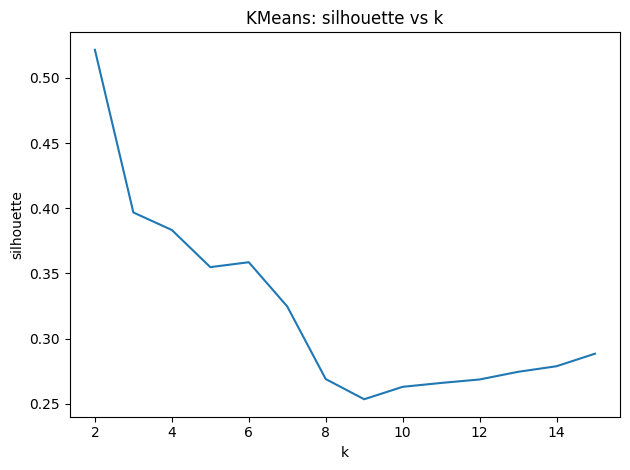

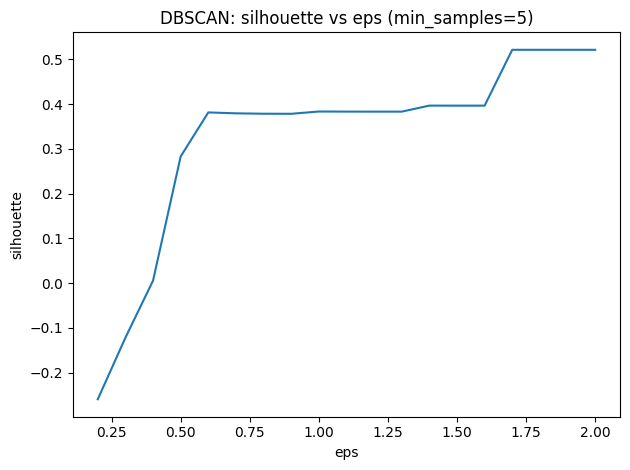

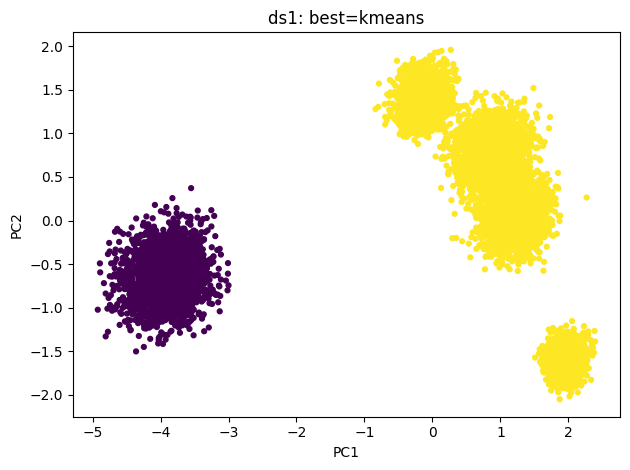

Best choice: {'algo': 'kmeans', 'k': 2, 'silhouette': 0.5216395622404242, 'davies_bouldin': 0.6853295219054459, 'calinski_harabasz': 11786.954622671528, 'noise_share': None, 'n_clusters': 2}
ds2 data/S07-hw-dataset-02.csv


,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB


None

,sample_id,x1,x2,z_noise
count,8000.00000,8000.000000,8000.000000,8000.000000
mean,3999.50000,0.478867,0.241112,0.110454
std,2309.54541,0.955138,0.663195,8.097716
min,0.00000,-2.487352,-2.499237,-34.056074
25%,1999.75000,-0.116516,-0.242357,-5.392210
50%,3999.50000,0.490658,0.241092,0.132470
75%,5999.25000,1.085263,0.726526,5.655605
max,7999.00000,2.987555,2.995553,29.460076


sample_id    0.0
x1           0.0
x2           0.0
z_noise      0.0
dtype: float64

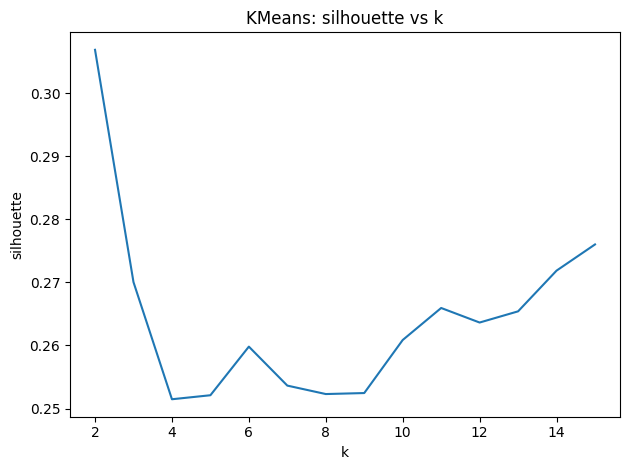

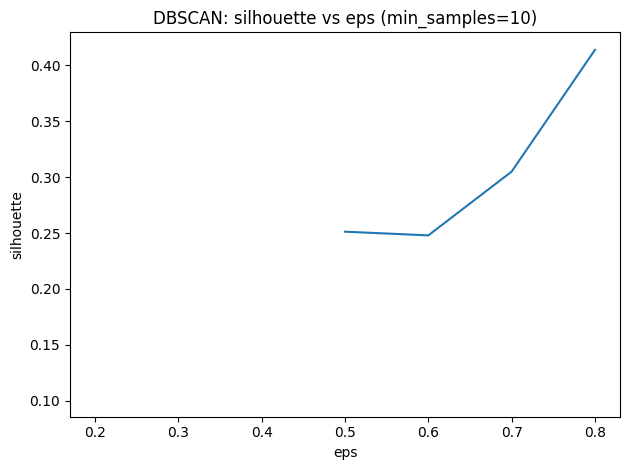

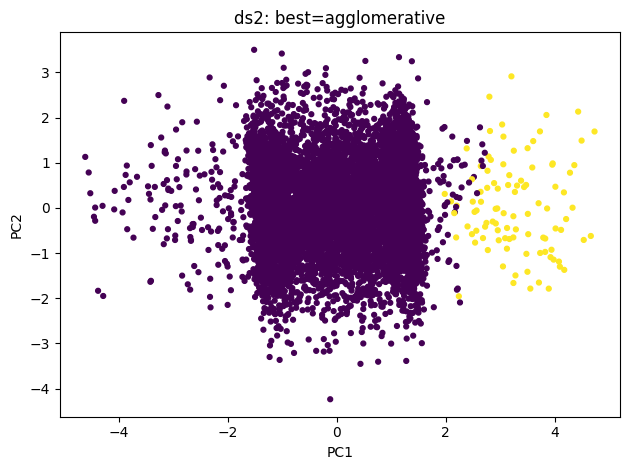

Best choice: {'algo': 'agglomerative', 'k': 2, 'linkage': 'average', 'silhouette': 0.41976775922231674, 'davies_bouldin': 0.879128779599685, 'calinski_harabasz': 395.48256948317135, 'noise_share': None, 'n_clusters': 2}
ds3 data/S07-hw-dataset-03.csv


,sample_id,x1,x2,f_corr,f_noise
0,0,-2.710470,4.997107,-1.015703,0.718508
1,1,8.730238,-8.787416,3.953063,-1.105349
2,2,-1.079600,-2.558708,0.976628,-3.605776
3,3,6.854042,1.560181,1.760614,-1.230946
4,4,9.963812,-8.869921,2.966583,0.915899


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB


None

,sample_id,x1,x2,f_corr,f_noise
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.246296,1.033764,0.212776,-0.027067
std,4330.271354,4.592421,4.710791,1.530017,2.506375
min,0.000000,-9.995585,-9.980853,-5.212038,-8.785884
25%,3749.750000,-1.782144,-2.666393,-0.966224,-1.731128
50%,7499.500000,0.664226,1.831257,0.296508,-0.052391
75%,11249.250000,4.435671,4.969630,1.390273,1.673831
max,14999.000000,16.207863,14.271153,5.795876,11.266865


sample_id    0.0
x1           0.0
x2           0.0
f_corr       0.0
f_noise      0.0
dtype: float64

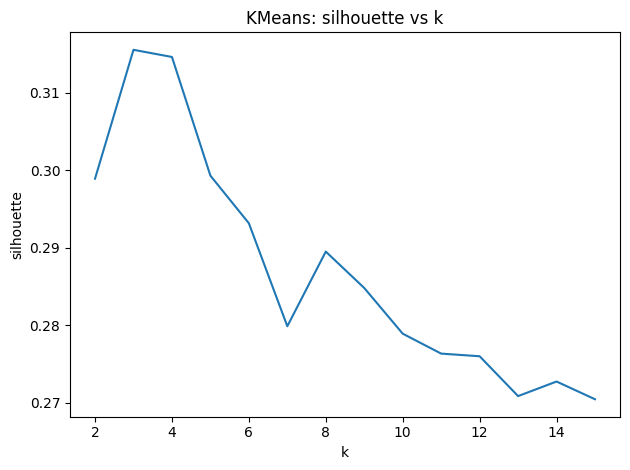

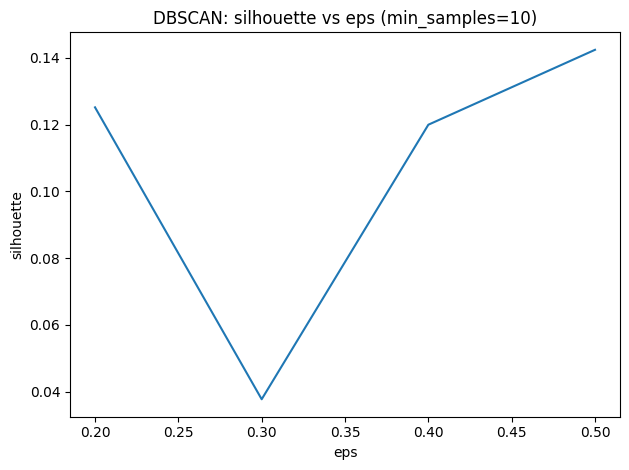

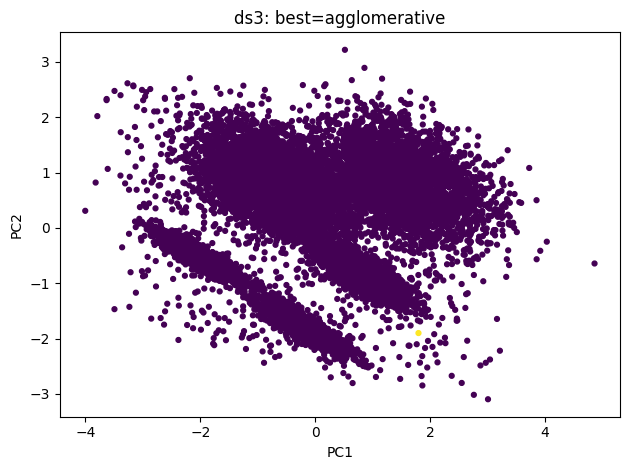

Best choice: {'algo': 'agglomerative', 'k': 2, 'linkage': 'average', 'silhouette': 0.42529612444453263, 'davies_bouldin': 0.813802016581118, 'calinski_harabasz': 8.943143115556799, 'noise_share': None, 'n_clusters': 2}


In [5]:
for ds_key, path in DATASETS.items():
    print("="*80)
    print(ds_key, path)

    df, sample_id, X = load_dataset(path)
    basic_eda(df)

    preprocess = build_preprocessor(X)
    X_scaled = preprocess.fit_transform(X)

    km_rows, km_best = search_kmeans(X_scaled, 2, 15)
    fig_path = os.path.join(FIG_DIR, f"{ds_key}_kmeans_silhouette_vs_k.png")
    plt.savefig(fig_path, dpi=160)
    plt.show()

    db_rows, db_best = search_dbscan(X_scaled)
    if db_best is not None:
        fig_path = os.path.join(FIG_DIR, f"{ds_key}_dbscan_silhouette_vs_eps.png")
        plt.savefig(fig_path, dpi=160)
        plt.show()

    ag_rows, ag_best = search_agglomerative(X_scaled, 2, 15, linkages=("ward", "average"))

    candidates = [r for r in [km_best, db_best, ag_best] if r is not None]
    best = max(candidates, key=lambda r: r["silhouette"]) if candidates else None

    if best is None:
        print("Не удалось подобрать модель с >=2 кластерами для метрик")
        continue

    if best["algo"] == "kmeans":
        model = KMeans(n_clusters=int(best["k"]), random_state=RANDOM_STATE, n_init=10)
        labels = model.fit_predict(X_scaled)
    elif best["algo"] == "dbscan":
        model = DBSCAN(eps=float(best["eps"]), min_samples=int(best["min_samples"]))
        labels = model.fit_predict(X_scaled)
    else:
        model = AgglomerativeClustering(n_clusters=int(best["k"]), linkage=str(best["linkage"]))
        labels = model.fit_predict(X_scaled)

    pca_path = os.path.join(FIG_DIR, f"{ds_key}_best_pca.png")
    pca_scatter(X_scaled, labels, title=f"{ds_key}: best={best['algo']}", save_path=pca_path)

    out_labels = pd.DataFrame({"sample_id": sample_id, "cluster_label": labels})
    labels_path = os.path.join(LABELS_DIR, f"labels_hw07_{ds_key}.csv")
    out_labels.to_csv(labels_path, index=False)

    metrics_summary[ds_key] = {
        "kmeans_best": km_best,
        "dbscan_best": db_best,
        "agglomerative_best": ag_best,
        "final_choice": best,
    }

    best_configs[ds_key] = best

    print("Best choice:", best)

In [6]:
metrics_path = os.path.join(ARTIFACTS_DIR, "metrics_summary.json")
with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(metrics_summary, f, ensure_ascii=False, indent=2)

best_path = os.path.join(ARTIFACTS_DIR, "best_configs.json")
with open(best_path, "w", encoding="utf-8") as f:
    json.dump(best_configs, f, ensure_ascii=False, indent=2)


## Устойчивость (только для одного датасета)

Проверка устойчивости для KMeans на `ds2`: 5 запусков с разными `random_state`, затем считаем средний ARI между разбиениями.


In [7]:
path = DATASETS["ds2"]
df, sample_id, X = load_dataset(path)
preprocess = build_preprocessor(X)
X_scaled = preprocess.fit_transform(X)

k = metrics_summary.get("ds2", {}).get("kmeans_best", {}).get("k")
if k is None:
    k = 3

labels_list = []
seeds = [1, 2, 3, 4, 5]
for seed in seeds:
    km = KMeans(n_clusters=int(k), random_state=seed, n_init=10)
    labels_list.append(km.fit_predict(X_scaled))

aris = []
for i in range(len(labels_list)):
    for j in range(i+1, len(labels_list)):
        aris.append(adjusted_rand_score(labels_list[i], labels_list[j]))

print(f"Stability for ds2 (KMeans k={k})")
print("pairwise ARI:", [round(a, 4) for a in aris])
print("mean ARI:", float(np.mean(aris)))

Stability for ds2 (KMeans k=2)
pairwise ARI: [0.999, 1.0, 1.0, 0.9995, 0.999, 0.999, 0.9995, 1.0, 0.9995, 0.9995]
mean ARI: 0.9995000374991841


## Сохранение артефактов (JSON)

In [8]:
with open(os.path.join(ARTIFACTS_DIR, "metrics_summary.json"), "w", encoding="utf-8") as f:
    json.dump(metrics_summary, f, ensure_ascii=False, indent=2)

with open(os.path.join(ARTIFACTS_DIR, "best_configs.json"), "w", encoding="utf-8") as f:
    json.dump(best_configs, f, ensure_ascii=False, indent=2)

print("Saved:")
print("-", os.path.join(ARTIFACTS_DIR, "metrics_summary.json"))
print("-", os.path.join(ARTIFACTS_DIR, "best_configs.json"))
print("- labels in", LABELS_DIR)
print("- figures in", FIG_DIR)

Saved:
- artifacts/metrics_summary.json
- artifacts/best_configs.json
- labels in artifacts/labels
- figures in artifacts/figures
